## Purpose: 

* Loading data 
* Training models according to pre-decided configurations 
* Evaluating using different metrics 

Inpiration taken from:
https://github.com/davej23/attention-mechanism-unet

### Load Packages

In [ ]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import register_keras_serializable



!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr


  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-ny8jftca
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-ny8jftca
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
  Using cached rarfile-4.1-py3-none-any.whl (28 kB)
  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  Using cached imageio-2.5.0-py3-none-any.whl (3.3 MB)
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=34361 sha256=03a43710eaa4bae52fa571d8af6324538a7b69a289e617156ed

### Functions:

Defining functions we will need throughout the training and reconstructing preducted images

In [ ]:
# Custom IoU metric

# Custom mean IoU metric for training anf validation 
@register_keras_serializable()
def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)) - y_true * K.round(y_pred))
    iou = intersection / (union + K.epsilon())
    return iou


In [ ]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction)

In [ ]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [ ]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

### Downloading and Processing RGB Dataset

In [ ]:
# Downloading data directly from site
download = True
base_dir = "Amazon Forest Dataset/data/"

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

In [ ]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [ ]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [ ]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [ ]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):

    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed)

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img,mask) in train_generator:
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [ ]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

### Downloading and processing 4-band Datasets

## 4-band Amazon dataset

In [ ]:
download = True # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [ ]:
# Amazon data:

# Download data (Amazon)

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()


In [ ]:
# Atlantic Forest data:

download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images and normalise

# training_images_list2

# Getting names of files from Amazon 4 band dataset:
training_images_list_amazon_only = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
# training_masks_list2

# Initializing empty lists of images and masks
training_masks_list_amazon_only = []
training_images_amazon_only = []
training_masks_amazon_only = []


training_images_all = []
training_masks_all = []

# Looping through list and acquiring images:
for n in training_images_list_amazon_only:
  # Appending list
  training_masks_list_amazon_only.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n)))[:3, :, :])
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  # Appending images
  training_images_amazon_only.append(a)
  training_images_all.append(a)

## Training masks

for n in training_masks_list_amazon_only:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks_amazon_only.append(a)
  training_masks_all.append(a)

## Test images
test_images_list_amazon_only = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list_amazon_only = []
test_images_amazon_only = []

test_images_all = []
test_masks_all = []

for n in test_images_list_amazon_only:
  test_masks_list_amazon_only.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n)))[:3, :, :])
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images_amazon_only.append(a)
  test_images_all.append(a)

## Test masks
test_masks_amazon_only = []
for n in test_masks_list_amazon_only:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks_amazon_only.append(a)
  test_masks_all.append(a)


## Validation images
validation_images_list_amazon_only = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list_amazon_only = []
validation_images_amazon_only = []

validation_images_all = []
validation_masks_all = []

for n in validation_images_list_amazon_only:
  validation_masks_list_amazon_only.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n)))[:3, :, :])
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images_amazon_only.append(a)
  validation_images_all.append(a)

## Validation masks
validation_masks_amazon_only = []
for n in validation_masks_list_amazon_only:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks_amazon_only.append(a)
  validation_masks_all.append(a)

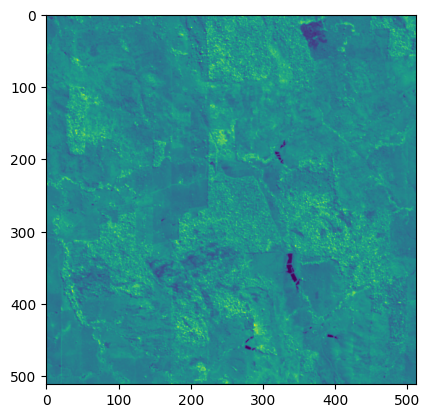

In [ ]:
# Seeing an example
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list_amazon_only[20])))[3,:,:]))


### Adding Atlantic data:

We are appending this to the Amazon forest dataset


In [ ]:
# Ingest images and normalise

## Training images
training_images_list_atlantic = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list_atlantic = []

for n in training_images_list_atlantic:
  training_masks_list_atlantic.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n)))[:3, :, :])
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images_all.append(a)

## Training masks

for n in training_masks_list_atlantic:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks_all.append(a)

## Test images
test_images_list_atlantic = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list_atlantic = []

for n in test_images_list_atlantic:
  test_masks_list_atlantic.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n)))[:3, :, :])
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images_all.append(a)

## Test masks
for n in test_masks_list_atlantic:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks_all.append(a)

## Validation images
validation_images_list_atlantic = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list_atlantic = []

for n in validation_images_list_atlantic:
  validation_masks_list_atlantic.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n)))[:3, :, :])
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images_all.append(a)

## Validation masks
for n in validation_masks_list_atlantic:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks_all.append(a)

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images_amazon_only)):
  training_images_amazon_only[i] = training_images_amazon_only[i].astype('float32')
  training_images_amazon_only[i] = training_images_amazon_only[i].T

for i in range(len(training_masks_amazon_only)):
  training_masks_amazon_only[i] = training_masks_amazon_only[i].reshape(1,512,512,1)
  training_masks_amazon_only[i] = training_masks_amazon_only[i].T

for i in range(len(validation_images_amazon_only)):
  validation_images_amazon_only[i] = validation_images_amazon_only[i].astype('float32')
  validation_images_amazon_only[i] = validation_images_amazon_only[i].T

for i in range(len(validation_masks_amazon_only)):
  validation_masks_amazon_only[i] = validation_masks_amazon_only[i].reshape(1,512,512,1)
  validation_masks_amazon_only[i] = validation_masks_amazon_only[i].T

for i in range(len(test_images_amazon_only)):
  test_images_amazon_only[i] = test_images_amazon_only[i].astype('float32')
  test_images_amazon_only[i] = test_images_amazon_only[i].T

for i in range(len(test_masks_amazon_only)):
  test_masks_amazon_only[i] = test_masks_amazon_only[i].reshape(1,512,512,1)
  test_masks_amazon_only[i] = test_masks_amazon_only[i].T

for i in range(len(training_images_amazon_only)):
  training_images_amazon_only[i] = training_images_amazon_only[i].reshape(-1,512,512,3)

# for i in range(len(validation_images_amazon_only)):
#  validation_images_amazon_only[i] = validation_images_amazon_only[i].reshape(-1,512,512,3)

for i in range(len(test_images_amazon_only)):
  test_images_amazon_only[i] = test_images_amazon_only[i].reshape(-1,512,512,3)

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images_all)):
  training_images_all[i] = training_images_all[i].astype('float32')
  training_images_all[i] = training_images_all[i].T

for i in range(len(training_masks_all)):
  training_masks_all[i] = training_masks_all[i].reshape(1,512,512,1)
  training_masks_all[i] = training_masks_all[i].T

for i in range(len(validation_images_all)):
  validation_images_all[i] = validation_images_all[i].astype('float32')
  validation_images_all[i] = validation_images_all[i].T

for i in range(len(validation_masks_all)):
  validation_masks_all[i] = validation_masks_all[i].reshape(1,512,512,1)
  validation_masks_all[i] = validation_masks_all[i].T

for i in range(len(test_images_all)):
  test_images_all[i] = test_images_all[i].astype('float32')
  test_images_all[i] = test_images_all[i].T

for i in range(len(test_masks_all)):
  test_masks_all[i] = test_masks_all[i].reshape(1,512,512,1)
  test_masks_all[i] = test_masks_all[i].T

for i in range(len(training_images_all)):
  training_images_all[i] = training_images_all[i].reshape(-1,512,512,3)

for i in range(len(validation_images_all)):
  validation_images_all[i] = validation_images_all[i].reshape(-1,512,512,3)

for i in range(len(test_images_all)):
  test_images_all[i] = test_images_all[i].reshape(-1,512,512,3)

#### Creating Tensors for 4-band images:

In [ ]:
# # Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images_amazon_only[0:250], training_masks_amazon_only[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images_amazon_only, validation_masks_amazon_only))

In [ ]:
# # Create TensorFlow datasets for training and validation sets
# 2 batches
train_df_4band_all = tf.data.Dataset.from_tensor_slices((training_images_all[0:250], training_masks_all[0:250]))
validation_df_4band_all = tf.data.Dataset.from_tensor_slices((validation_images_all, validation_masks_all))

In [ ]:
print(len(training_images_amazon_only))
print(len(training_images_all))

250
500


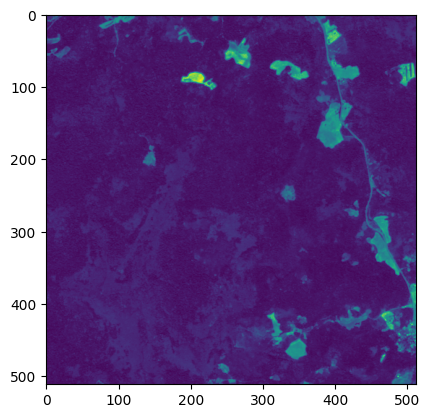

In [ ]:
# Plot example training image first band
plt.imshow(training_images_all[254].reshape(512,512,4)[:,:,0])

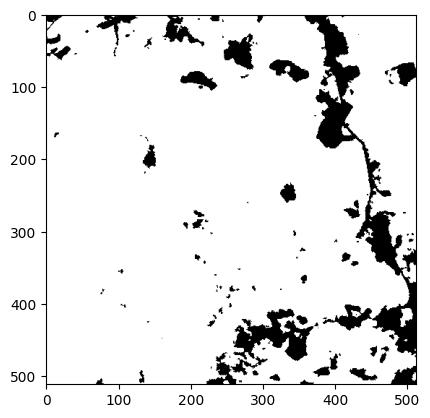

In [ ]:
plt.imshow(training_masks_all[254].reshape(512,512,1), cmap = 'gray')

# Models

## U-Net

In [ ]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

'''
  U-Net model
'''

def UNet(trained_weights = None,
         input_size = (512,512,3),
         drop_rate = 0.25,
         lr=0.0001,
         loss_choice = 'binary_crossentropy',
         metrics_choice = ['accuracy', 'mse']):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = 'Adam', loss = loss_choice, metrics = metrics_choice)

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
# Print model layers and number of parameters
UNet().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (1, 512, 512, 64)            1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (1, 512, 512, 64)            0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (1, 512, 512, 64)            36928     ['activation[0][0]']          
                                                                                              

## Attention U-Net

In [ ]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv

'''
  Attention block/mechanism
'''
def attention_block(x,
                    gating,
                    inter_shape,
                    drop_rate=0.25):

    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16,
                    loss_choice = 'binary_crossentropy',
           metrics_choice = ['accuracy', 'mse']):


    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = 'Adam', loss = loss_choice, metrics = metrics_choice)

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (1, 512, 512, 16)            448       ['input_2[0][0]']             
                                                                                                  
 activation_19 (Activation)  (1, 512, 512, 16)            0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_19[0][0]']       
                                                                                            

# Train on RGB feature data

## U-Net

In [ ]:
model_unet_iou = UNet(input_size=(512, 512, 3), lr=0.0001,
                  loss_choice='binary_crossentropy',
                  metrics_choice=['accuracy', 'mse', mean_iou])

# Define early stopping based on custom mIoU metric
# early_stopping = EarlyStopping(monitor='val_mIoU', patience=10, restore_best_weights=True)

save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_mean_iou', verbose=1, save_best_only=True)

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet_iou_history = model_unet_iou.fit(train, steps_per_epoch=1, epochs=100,
               validation_data=validation_df, callbacks=[save_model])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5236 - mse: 0.2484 - mean_iou: 0.4441
Epoch 1: val_mean_iou improved from inf to 0.52950, saving model to unet-3d.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 25s 25s/step - loss: 0.6900 - accuracy: 0.5236 - mse: 0.2484 - mean_iou: 0.4441 - val_loss: 3.2491 - val_accuracy: 0.5295 - val_mse: 0.4637 - val_mean_iou: 0.5295
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 6.0691 - accuracy: 0.0725 - mse: 0.9148 - mean_iou: 0.0725
Epoch 2: val_mean_iou improved from 0.52950 to 0.52949, saving model to unet-3d.hdf5
1/1 [==============================] - 2s 2s/step - loss: 6.0691 - accuracy: 0.0725 - mse: 0.9148 - mean_iou: 0.0725 - val_loss: 0.6399 - val_accuracy: 0.5295 - val_mse: 0.2254 - val_mean_iou: 0.5295
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.8122 - accuracy: 0.2433 - mse: 0.3090 - mean_iou: 0.2433
Epoch 3: val_mean_iou did not improve from 0.52949
1/1 [==============================] - 2s 2s/step - loss: 0.8122 - accuracy: 0.2433 - mse: 0.3090 - mean_iou: 0.2433 - val_loss: 0.6648 - val_accuracy: 0.7793 - val_mse: 0.2358 - val_mean_iou: 0.5298
Epoch 4/10

In [ ]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001,
                  metrics_choice=['accuracy', 'mse', mean_iou])
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet_history = model_unet.fit(train, steps_per_epoch=1, epochs=100, validation_data = validation_df, callbacks=[save_model])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6802 - mse: 0.2286 - mean_iou: 0.6773
Epoch 1: val_accuracy improved from -inf to 0.52949, saving model to unet-3d.hdf5
1/1 [==============================] - 9s 9s/step - loss: 0.6499 - accuracy: 0.6802 - mse: 0.2286 - mean_iou: 0.6773 - val_loss: 26.4708 - val_accuracy: 0.5295 - val_mse: 0.4704 - val_mean_iou: 0.5295
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 48.5428 - accuracy: 0.0725 - mse: 0.9273 - mean_iou: 0.0725
Epoch 2: val_accuracy did not improve from 0.52949
1/1 [==============================] - 2s 2s/step - loss: 48.5428 - accuracy: 0.0725 - mse: 0.9273 - mean_iou: 0.0725 - val_loss: 0.6830 - val_accuracy: 0.5295 - val_mse: 0.2495 - val_mean_iou: 0.5295
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.2433 - mse: 0.4198 - mean_iou: 0.2433
Epoch 3: val_accuracy improved from 0.52949 to 0.52962, saving model to unet-3d.hdf5
1

In [ ]:
model_unet.save("model_unet_from_base_experimentation.keras", overwrite=True, save_format=None)

In [1]:
# Plot accuracy and loss

## Accuracy
plt.plot(model_unet_history.history['accuracy'])
plt.plot(model_unet_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Model: U-Net with metric val_accuracy")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Model_UNET_regular_3B_accuracy.png')  # Save the figure as a PNG image

## Mean IoU
plt.plot(model_unet_history.history['mean_iou'])
plt.plot(model_unet_history.history['val_mean_iou'])
plt.ylabel('mIoU')
plt.xlabel('Epoch')
plt.title("Model: U-Net with metric val_accuracy")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Model_UNET_regular_3B_accuracy.png')  # Save the figure as a PNG image

## Loss
plt.plot(model_unet_history.history['loss'])
plt.plot(model_unet_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Model: U-Net with metric val_accuracy")
plt.savefig('Model_UNET_regular_3B_loss.png')  # Save the figure as a PNG image
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet_mean_iou = UNetAM(lr=0.0005, filter_base=16,
                  metrics_choice=['accuracy', 'mse', mean_iou])
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_mean_iou',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
history_mean_iou = model_attention_unet_mean_iou.fit(train, steps_per_epoch=10, epochs= 200, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5076 - mse: 0.2496 - mean_iou: 0.4840
Epoch 1: val_mean_iou improved from inf to 0.52940, saving model to unet-attention-3d.hdf5
10/10 [==============================] - 13s 151ms/step - loss: 0.6924 - accuracy: 0.5076 - mse: 0.2496 - mean_iou: 0.4840 - val_loss: 0.6735 - val_accuracy: 0.5301 - val_mse: 0.2403 - val_mean_iou: 0.5294
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.3680 - mse: 0.2510 - mean_iou: 0.3679
Epoch 2: val_mean_iou did not improve from 0.52940
10/10 [==============================] - 1s 81ms/step - loss: 0.6950 - accuracy: 0.3680 - mse: 0.2510 - mean_iou: 0.3679 - val_loss: 0.6651 - val_accuracy: 0.5295 - val_mse: 0.2361 - val_mean_iou: 0.5295
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.4276 - mse: 0.2472 - mean_iou: 0.4272
Epoch 3: val_mean_iou improved from 0.52940 to 0.52904, saving model to unet-attention-3d.hdf5
10/10 [==============================] - 1s 100ms/step - loss: 0.6875 - accuracy: 0.4276 - mse: 0.2472 - mean_iou: 0.4272 - val_loss: 0.6568 - val_accuracy: 0.5296 - val_mse: 0.2320 - val_mean_iou: 0.5290
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.4647 - mse: 0.2370 - mean_iou: 0.4640
Epoch 4: val_mean_iou did not improve from 0.52904
10/10 [===============

In [ ]:
model_attention_unet.save("model_attention_unet_from_base_experimentation.keras", overwrite=True, save_format=None)

In [ ]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16,
                  metrics_choice=['accuracy', 'mse', mean_iou])
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
history_attn_unet = model_attention_unet.fit(train, steps_per_epoch=10, epochs= 200, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 0.7243 - accuracy: 0.4485 - mse: 0.2649 - mean_iou: 0.3522
Epoch 1: val_accuracy improved from -inf to 0.61581, saving model to unet-attention-3d.hdf5
10/10 [==============================] - 9s 152ms/step - loss: 0.7243 - accuracy: 0.4485 - mse: 0.2649 - mean_iou: 0.3522 - val_loss: 0.6734 - val_accuracy: 0.6158 - val_mse: 0.2402 - val_mean_iou: 0.5447
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.6306 - mse: 0.2397 - mean_iou: 0.3184
Epoch 2: val_accuracy did not improve from 0.61581
10/10 [==============================] - 1s 81ms/step - loss: 0.6780 - accuracy: 0.6306 - mse: 0.2397 - mean_iou: 0.3184 - val_loss: 0.7674 - val_accuracy: 0.4734 - val_mse: 0.2833 - val_mean_iou: 0.0066
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.6012 - mse: 0.2405 - mean_iou: 0.1047
Epoch 3: val_accuracy improved from 0.61581 to 0.89843, saving m

In [ ]:
model_unet_iou.save("model_unet_iou.keras", overwrite=True)
model_unet.save("model_unet.keras", overwrite=True)
model_attention_unet.save("model_attention_unet.keras", overwrite = True)
model_attention_unet_mean_iou.save("model_attention_unet_mean_iou.keras", overwrite = True)

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [ ]:
# Train U-Net with generator

# Accuracy:
model_unet_4band = UNet(input_size = (512,512,4), lr=0.0001,
                  loss_choice='binary_crossentropy',
                  metrics_choice=['accuracy', 'mse', mean_iou])

save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_history = model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8762 - mse: 0.0924 - mean_iou: 0.7384
Epoch 1: val_accuracy improved from -inf to 0.93239, saving model to unet-4d.hdf5
250/250 [==============================] - 73s 269ms/step - loss: 0.3210 - accuracy: 0.8762 - mse: 0.0924 - mean_iou: 0.7384 - val_loss: 0.1747 - val_accuracy: 0.9324 - val_mse: 0.0505 - val_mean_iou: 0.7939
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9307 - mse: 0.0531 - mean_iou: 0.8254
Epoch 2: val_accuracy improved from 0.93239 to 0.94680, saving model to unet-4d.hdf5
250/250 [==============================] - 66s 266ms/step - loss: 0.1850 - accuracy: 0.9307 - mse: 0.0531 - mean_iou: 0.8254 - val_loss: 0.1357 - val_accuracy: 0.9468 - val_mse: 0.0391 - val_mean_iou: 0.8295
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9396 - mse: 0.0453 - mean_iou: 0.8500
Epoch 3: val_accuracy improved

In [ ]:
# Train U-Net with generator

# Accuracy:
model_unet_4band_all = UNet(input_size = (512,512,4), lr=0.0001,
                  loss_choice='binary_crossentropy',
                  metrics_choice=['accuracy', 'mse', mean_iou])

save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_history = model_unet_4band_all.fit(train_df_4band_all, epochs = 20, validation_data = validation_df_4band_all, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8602 - mse: 0.1040 - mean_iou: 0.7158
Epoch 1: val_accuracy improved from -inf to 0.87978, saving model to unet-4d.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 80s 298ms/step - loss: 0.3466 - accuracy: 0.8602 - mse: 0.1040 - mean_iou: 0.7158 - val_loss: 0.3274 - val_accuracy: 0.8798 - val_mse: 0.0931 - val_mean_iou: 0.7115
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9186 - mse: 0.0615 - mean_iou: 0.7974
Epoch 2: val_accuracy improved from 0.87978 to 0.88367, saving model to unet-4d.hdf5
250/250 [==============================] - 73s 294ms/step - loss: 0.2124 - accuracy: 0.9186 - mse: 0.0615 - mean_iou: 0.7974 - val_loss: 0.3262 - val_accuracy: 0.8837 - val_mse: 0.0901 - val_mean_iou: 0.7286
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9338 - mse: 0.0500 - mean_iou: 0.8328
Epoch 3: val_accuracy improved from 0.88367 to 0.89427, saving model to unet-4d.hdf5
250/250 [==============================] - 73s 293ms/step - loss: 0.1715 - accuracy: 0.9338 - mse: 0.0500 - mean_iou: 0.8328 - val_loss: 0.2997 - val_accura

In [ ]:
# Train U-Net with generator

# Accuracy:
model_unet_4band_iou = UNet(input_size = (512,512,4), lr=0.0001,
                  loss_choice='binary_crossentropy',
                  metrics_choice=['accuracy', 'mse', mean_iou])

save_model_4band = ModelCheckpoint('unet-4d-iou.hdf5', monitor='val_mean_iou',verbose=1, save_best_only=True)
model_unet_4band_history = model_unet_4band_iou.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.8659 - mse: 0.1003 - mean_iou: 0.7264
Epoch 1: val_mean_iou improved from inf to 0.77633, saving model to unet-4d-iou.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 72s 268ms/step - loss: 0.4939 - accuracy: 0.8659 - mse: 0.1003 - mean_iou: 0.7264 - val_loss: 0.1981 - val_accuracy: 0.9252 - val_mse: 0.0572 - val_mean_iou: 0.7763
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.9157 - mse: 0.0670 - mean_iou: 0.7921
Epoch 2: val_mean_iou did not improve from 0.77633
250/250 [==============================] - 66s 262ms/step - loss: 0.2603 - accuracy: 0.9157 - mse: 0.0670 - mean_iou: 0.7921 - val_loss: 0.1662 - val_accuracy: 0.9365 - val_mse: 0.0477 - val_mean_iou: 0.7958
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9271 - mse: 0.0549 - mean_iou: 0.8208
Epoch 3: val_mean_iou did not improve from 0.77633
250/250 [==============================] - 65s 259ms/step - loss: 0.1872 - accuracy: 0.9271 - mse: 0.0549 - mean_iou: 0.8208 - val_loss: 0.1353 - val_accuracy: 0.9473 - val_mse: 0.0391 - val_mean_iou: 0.8372
Epoch 4/20
250/2

In [ ]:
# Train U-Net with generator

# Accuracy:
model_unet_4band_iou_all = UNet(input_size = (512,512,4), lr=0.0001,
                  loss_choice='binary_crossentropy',
                  metrics_choice=['accuracy', 'mse', mean_iou])

save_model_4band = ModelCheckpoint('unet-4d-iou.hdf5', monitor='val_mean_iou',verbose=1, save_best_only=True)
model_unet_4band_history = model_unet_4band_iou_all.fit(train_df_4band_all, epochs = 20, validation_data = validation_df_4band_all, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.8347 - accuracy: 0.8596 - mse: 0.1022 - mean_iou: 0.6959
Epoch 1: val_mean_iou improved from inf to 0.71040, saving model to unet-4d-iou.hdf5
250/250 [==============================] - 80s 298ms/step - loss: 0.8347 - accuracy: 0.8596 - mse: 0.1022 - mean_iou: 0.6959 - val_loss: 0.3202 - val_accuracy: 0.8809 - val_mse: 0.0919 - val_mean_iou: 0.7104
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.9057 - mse: 0.0728 - mean_iou: 0.7766
Epoch 2: val_mean_iou did not improve from 0.71040
250/250 [==============================] - 73s 292ms/step - loss: 0.2734 - accuracy: 0.9057 - mse: 0.0728 - mean_iou: 0.7766 - val_loss: 0.3222 - val_accuracy: 0.8811 - val_mse: 0.0908 - val_mean_iou: 0.7168
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9238 - mse: 0.0569 - mean_iou: 0.8078
Epoch 3: val_mean_iou did not improve from 0.71040
250/250 [=

# Final Thing

1/1 [==============================] - 0s 30ms/step


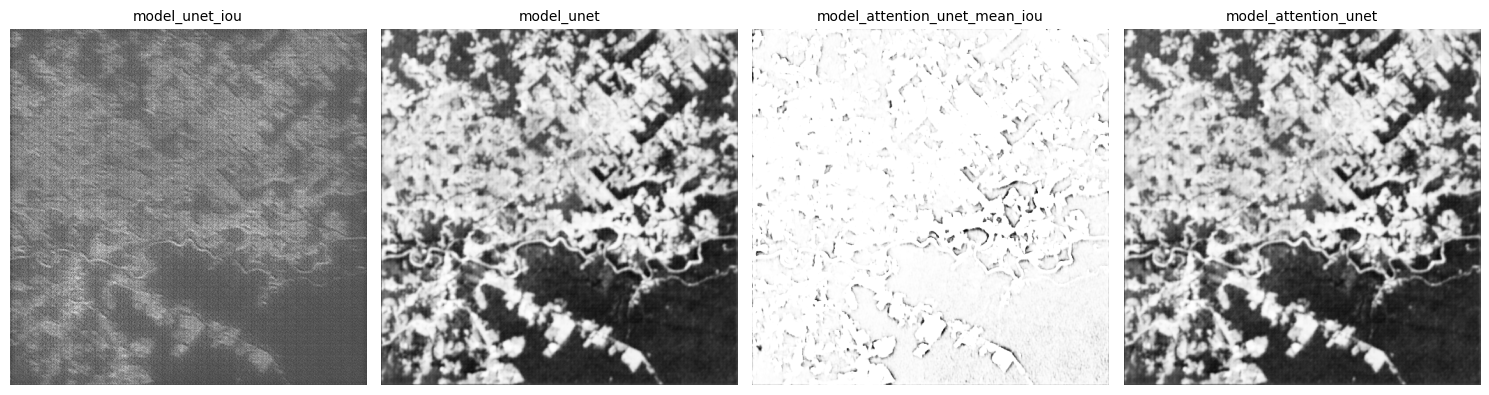

In [ ]:
titles_list = ['model_unet_iou', 'model_unet', 'model_attention_unet_mean_iou', 'model_attention_unet',
               'model_unet_4band_all', 'model_unet_4band','model_unet_4band_iou_all', 'model_unet_4band_iou']

images_list = [model_unet_3band_iou, model_unet_3band, model_attention_unet_3band_iou, model_attention_unet_3band,
               model_unet_4band_all_image, model_unet_4band_amazon,model_unet_4band_iou_all_image, model_unet_4band_amazon_iou_image]
model_unet_4band_all_image = reconstruct_array(model_unet_4band_all, reshaped_image, rounded=False)

# Create a figure with 1 row and 5 columns
fig, axes = plt.subplots(1, len(titles_list[:4]), figsize=(15, 5))

# Loop through the images and plot them in each subplot
for i in range(len(titles_list[:4])):
    axes[i].imshow(images_list[i], cmap='gray')
    axes[i].axis('off')  # Optional: turn off axis labels for cleaner visualization
    axes[i].set_title(titles_list[i], fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
model_unet_4band_image = reconstruct_array(model_unet_4band, bolivia_img_batch, rounded=False)
plt.imshow(model_unet_4band_image, cmap = 'gray')

In [ ]:
model_attention_unet_4band_image = reconstruct_array(model_attention_unet_4band, bolivia_img_batch, rounded=False)

plt.imshow(model_attention_unet_4band_image, cmap = 'gray')

# Import Models and Compute Metrics

## RGB

In [ ]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

In [2]:
# Scores of each model
unet_score = (score_eval(model_unet, validation_images, validation_masks))
am_unet_score = (score_eval(model_attention_unet, validation_images, validation_masks))

iou_unet_score = (score_eval(model_unet_iou, validation_images, validation_masks))
iou_am_unet_score = (score_eval(model_attention_unet_mean_iou, validation_images, validation_masks))



print("Unet Score: ", np.mean(unet_score), "Attn Unet Score: ", np.mean(am_unet_score))
print("Mean IoU:")
print("Unet Score: ", np.mean(iou_unet_score), "Attn Unet Score: ", np.mean(iou_am_unet_score))


In [3]:
# Scores of each model
unet_precision = (precision_eval(model_unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(model_attention_unet, validation_images, validation_masks))

iou_unet_precision = (precision_eval(model_unet_iou, validation_images, validation_masks))
iou_am_unet_precision = (precision_eval(model_attention_unet_mean_iou, validation_images, validation_masks))

print("Unet Score: ", np.mean(unet_precision), "Attn Unet Score: ", np.mean(am_unet_precision))
print("Mean IoU:")
print("Unet Score: ", np.mean(iou_unet_precision), "Attn Unet Score: ", np.mean(iou_am_unet_precision))


In [4]:
# Scores of each model
unet_recall = (recall_eval(model_unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(model_attention_unet, validation_images, validation_masks))

iou_unet_recall = (recall_eval(model_unet_iou, validation_images, validation_masks))
iou_am_unet_recall = (recall_eval(model_attention_unet_mean_iou, validation_images, validation_masks))



print("Unet Score: ", np.mean(unet_recall), "Attn Unet Score: ", np.mean(am_unet_recall))
print("Mean IoU:")
print("Unet Score: ", np.mean(iou_unet_recall), "Attn Unet Score: ", np.mean(iou_am_unet_recall))


In [5]:
# Scores of each model
unet_f1 = (f1_score_eval_basic(unet_precision,unet_recall))
am_unet_f1 = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

iou_unet_f1 = (f1_score_eval_basic(iou_unet_precision,iou_unet_recall))
iou_am_unet_f1 = (f1_score_eval_basic(iou_am_unet_precision, iou_am_unet_recall))



print("Unet Score: ", np.mean(unet_f1), "Attn Unet Score: ", np.mean(am_unet_f1))
print("Mean IoU:")
print("Unet Score: ", np.mean(iou_unet_f1), "Attn Unet Score: ", np.mean(iou_am_unet_f1))


## 4-band

### Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

# Scores for amazon only:

In [ ]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

## Predictions:

In [ ]:
import cv2
bolivia_path = "/content/L15-0628E-0961N.tif"
a = (np.array(rxr.open_rasterio(bolivia_path)))
a = (a-np.min(a)) / (np.max(a)-np.min(a))

output_size = (512, 512)

# Reshape and resize using cv2.resize
reshaped_image = cv2.resize(a.transpose(1, 2, 0), output_size)

# Select the first three channels
reshaped_image = reshaped_image[:, :, :3]

# Add an additional dimension for batch size
reshaped_image = reshaped_image[np.newaxis, :, :, :]

# Verify the shape of the reshaped image
print(reshaped_image.shape)



In [ ]:
# Outdated:
bolivia_img = cv2.imread(bolivia_path)
bolivia_img_resize = cv2.resize(bolivia_img, (512, 512))
bolivia_img_resize.shape
bolivia_img_batch = np.expand_dims(bolivia_img_resize, axis=0)
bolivia_img_batch.shape

In [ ]:
model_unet_3band_iou = reconstruct_array(model_unet_iou, reshaped_image, rounded=False)
reshaped_image_denormalized = model_unet_3band_iou*255
plt.imshow(reshaped_image_denormalized, cmap = 'gray')

In [ ]:
model_unet_3band = reconstruct_array(model_unet, reshaped_image, rounded=False)
reshaped_image_denormalized = model_unet_3band*255
plt.imshow(model_unet_3band, cmap = 'gray')

In [ ]:
model_attention_unet_3band_iou = reconstruct_array(model_attention_unet_mean_iou,reshaped_image , rounded=False)
# denormalized_reshaped_image = model_attention_unet_3band * 255
plt.imshow(model_attention_unet_3band_iou, cmap = 'gray')

In [ ]:
model_attention_unet_3band = reconstruct_array(model_attention_unet, reshaped_image, rounded=False)
denormalized_reshaped_image = model_attention_unet_3band * 255
plt.imshow(model_attention_unet_3band, cmap = 'gray')